In [1]:
#library imports
import pandas as pd
import re
import nltk
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
import joblib

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abhure\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
#load files
csv_file_path1 = "C:/Users/abhure/Documents/SEM3/Text Analytics/Project/Data/raw data/all-data.csv"
csv_file_path2 = "C:/Users/abhure/Documents/SEM3/Text Analytics/Project/Data/raw data/RoBERTaWeaklyLabelling.csv"
try:
    df1 = pd.read_csv(csv_file_path1, encoding='utf-8')
except UnicodeDecodeError:
    df1 = pd.read_csv(csv_file_path1, encoding='latin1')
try:
    df2 = pd.read_csv(csv_file_path2, encoding='utf-8')
except UnicodeDecodeError:
    df2 = pd.read_csv(csv_file_path2, encoding='latin1')

In [4]:
# Concatenate dataframes
if set(df1.columns) == set(df2.columns):
    df = pd.concat([df1, df2], ignore_index=True)
else:
    column_mapping = {'news': 'news', 'label': 'label'}
    df2 = df2.rename(columns=column_mapping)
    df = pd.concat([df1, df2], ignore_index=True)

df.dropna(inplace=True)

In [5]:
df['label'] = df['label'].apply(lambda x: x.lower())

In [8]:
lemmatizer = nltk.stem.WordNetLemmatizer() #lemmatizer initialization
stop_words = set(nltk.corpus.stopwords.words('english'))

In [9]:
#data preprocessing
def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.lower()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

df['news'] = df['news'].apply(preprocess_text)

In [10]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(df['news'], df['label'], test_size=0.2, random_state=42, stratify=df['label'])

In [11]:
#create pipeline for selecting best parameters
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000, solver='liblinear'))
])

In [12]:
#defining the param grid
param_grid = {
    'tfidf__max_df': [0.7, 0.8, 0.9, 1.0],
    'tfidf__min_df': [1, 2, 3, 5],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__C': [0.1, 1, 10, 100]
}

In [13]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf',
                                        LogisticRegression(max_iter=1000,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10, 100],
                         'tfidf__max_df': [0.7, 0.8, 0.9, 1.0],
                         'tfidf__min_df': [1, 2, 3, 5],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             verbose=2)

In [14]:
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

Best Parameters: {'clf__C': 10, 'tfidf__max_df': 0.7, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1)}


In [15]:
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8645983017635532


In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.85      0.77      0.81      3424
     neutral       0.85      0.91      0.88      5299
    positive       0.88      0.88      0.88      6587

    accuracy                           0.86     15310
   macro avg       0.86      0.85      0.86     15310
weighted avg       0.86      0.86      0.86     15310



Positive class has the highest precision and recall, indicating strong performance in identifying 'positive' instances accurately.

Neutral class has the highest recall but the same precision as 'negative'. This shows that the model is very effective in capturing 'neutral' instances but with slightly lower precision compared to 'positive'.

Negative class has slightly lower recall compared to 'neutral' and 'positive' but performs well in precision.

In [17]:
joblib.dump(grid_search, 'sentiment_analysis_model.pkl')

['sentiment_analysis_model.pkl']

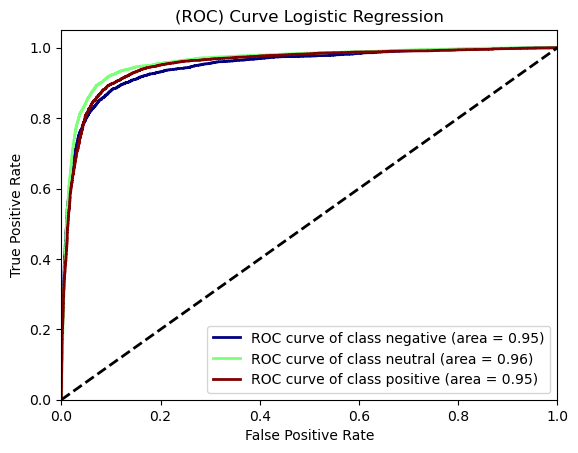

In [20]:
# ROC Curve Plotting
# Predict probabilities for the test set
y_score = grid_search.predict_proba(X_test)

# Binarize the labels
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

# Compute ROC curve and ROC AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
n_classes = y_test_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure()
colors = plt.cm.jet(np.linspace(0, 1, n_classes))
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {lb.classes_[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve Logistic Regression')
plt.legend(loc="lower right")
plt.show()

The ROC curve for Logistic Regression displayed good performance, supporting its accuracy results. It provides a balanced view of sensitivity and specificity across different thresholds.

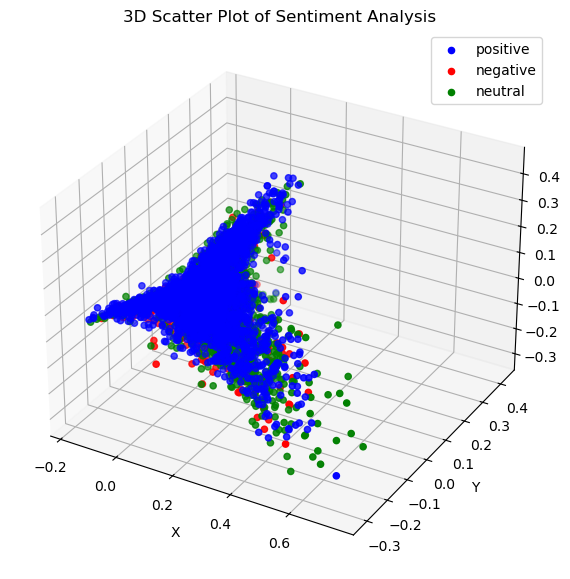

In [19]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

tfidf = grid_search.best_estimator_.named_steps['tfidf']
X_test_tfidf = tfidf.transform(X_test)

pca = PCA(n_components=3)
X_test_pca = pca.fit_transform(X_test_tfidf.toarray())

# Create a DataFrame for the 3D plot
df_3d = pd.DataFrame(X_test_pca, columns=['x', 'y', 'z'])
df_3d['label'] = y_test.values
df_3d['predicted'] = y_pred

# Plot 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
colors = {'positive': 'blue', 'negative': 'red', 'neutral': 'green'}

for label in df_3d['label'].unique():
    indices = df_3d['label'] == label
    ax.scatter(df_3d[indices]['x'], df_3d[indices]['y'], df_3d[indices]['z'], c=colors[label], label=label, s=20)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Scatter Plot of Sentiment Analysis')
ax.legend()
plt.show()
